In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 4. Second order methods

### 4.1 General recommendations
Second order methods use second order information, i.e. the hessian matrix.

There are two main classes of second order methods, ones that explicitly use the hessian matrix, thus requiring $N^2$ memory, and matrix-free methods that are suitable for very large scale optimization.

The explicit Newton's method (`tz.m.Newton`) is suitable for small-scale smooth convex problems, and it can significantly outperform quasi-newton methods in terms of time needed to converge.

A modified Newton's method (`tz.m.Newton(eigval_fn=lambda x: x.abs().clip(min=1e-8))`) is suitable for non-convex problems such as tiny neural networks, and can also be significantly faster than quasi-newton methods.

In torchzero, since we rely on PyTorch autograd, Newton's method appears to be efficient under ~400 variables. It will also depend largely on how well PyTorch can vectorize the hessian-vector products for a particular function.

Matrix-free Newton (`tz.m.NewtonCG`) uses about $4N$ memory because only needs to store a few variables. It is well suited for very large scale convex problems (e.g. 100,000,000 variables), however for non-convex or very badly scaled problems single step my be slow to compute and require many hessian-vector products. Modifications suitable for non-convex problems exist too.

Newton is usually used with a line search or with a trust region.

And now we shall review all the second order methods available in torchzero.

### 4.2 Newton's method
**Newton's method**, also known as Newton–Raphson method, is a root-finding method used to find solutions to equation $f(x)=0$.

In order to use Newton's method to minimize a function, we can use it to find solutions to $f'(x)=0$, i.e. the critical points (points where gradient is zero). As long as $f$ is twice-differentiable, any solution to $f'(x)=0$ is either minimum, maximum or a saddle point. Therefore if the function has maximums or saddle points, one needs to be careful as standard Newton's method may converge to them instead of the desired minimum.


The Newton iteration is:
$$
x_{t+1} \leftarrow x_t - H(x_t)^{-1}\nabla f(x_t)
$$

So on each step inverse hessian times gradient is subtracted from parameters.

In practice the Newton step is computed as a solution to a linear system because that is faster to compute:
$$
\text{solve:}\\\\ H(x_t)v_t = \nabla f(x_t)
$$
$$
x_{t+1} \leftarrow x_t - v_t
$$

Another interpretation of the Newton's method is that it constructs and minimizes a quadratic approximation of the objective function. Therefore if the objective function is quadratic, the approximation will be perfect and Newton's method converges in a single step with step size of 1.

Consider the following hessian for a function of two variables $x_1$ and $x_2$:
$$
\begin{bmatrix}
10 & 8\\
8 & 10
\end{bmatrix}
$$

Values of this matrix are double the coefficients of the quadratic model. That is because derivative of $x^2$ is $2x$, so the function with that derivative the coefficients are divided by two. So the quadratic model given by hessian above is:
$$
f(x_1, x_2) = (10x_1x_1 + 8x_1x_2 + 8x_2x_1 + 10x_2x_2) / 2
$$
Which is:
$$
f(x_1, x_2) = 5x_1^2 + 5x_2^2 + 8x_1x_2
$$

Now suppose the gradient $\nabla f(x_t)$ is $\frac{df}{dx_1}=6, \frac{df}{dx_2}=-4$, so it is $[6, -4]$, the model becomes:
$$
f(x_1, x_2) = \underbrace{5x_1^2 + 5x_2^2 + 8x_1x_2}_{\frac{1}{2}\mathbf{x}^T H \mathbf{x}} + \underbrace{6x_1 - 4x_2}_{\mathbf{g}^T \mathbf{x}}
$$

Or in a more general form, given gradient $g$ and hessian $H$, the model is:
$$
f(x) = \frac{1}{2}x^T H x + g^T x
$$
A Newton step with a step size of 1 minimizes this quadratic model of the objective function.

finished in 0.7s., reached loss = 0.000146                                      
finished in 0.3s., reached loss = 0                                      


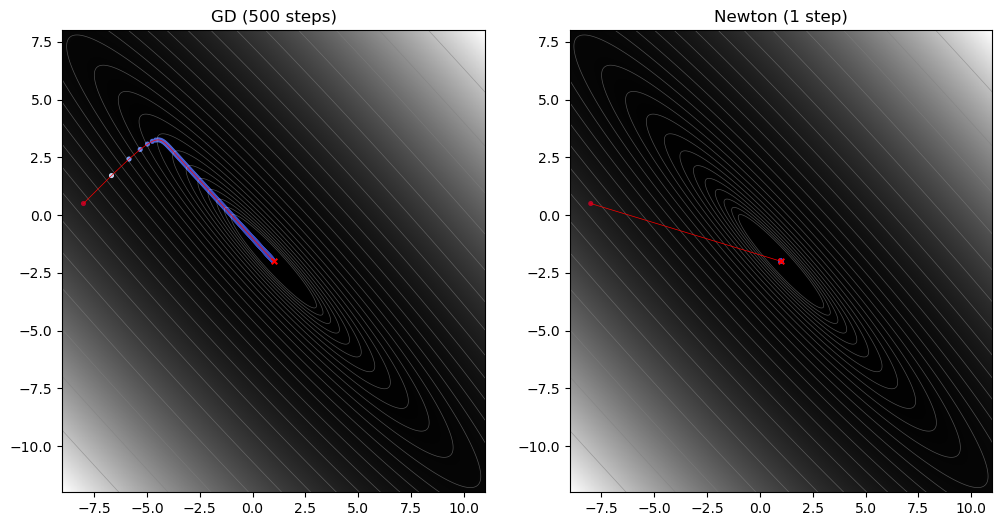

In [2]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# GD
func = FunctionDescent('ill1')
optimizer = tz.Modular(func.parameters(), tz.m.LR(1e-1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("GD (500 steps)")

# Newton
func = FunctionDescent('ill1')
optimizer = tz.Modular(func.parameters(), tz.m.Newton(), tz.m.LR(1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Newton (1 step)")

plt.show()

### 4.3 Dampened Newton
**Dampened Newton** is simply Newton's method with a step size that is allowed to be smaller than 1, for example it can be selected via a line search.

$$
x_{t+1} \leftarrow x_t - \eta H(x_t)^{-1}\nabla f(x_t)
$$

where $\eta$ is the step size.

This is often a better choice as Newton can be very unstable on some functions, especially non-convex ones.

finished in 0.1s., reached loss = 0                                      


<Axes: >

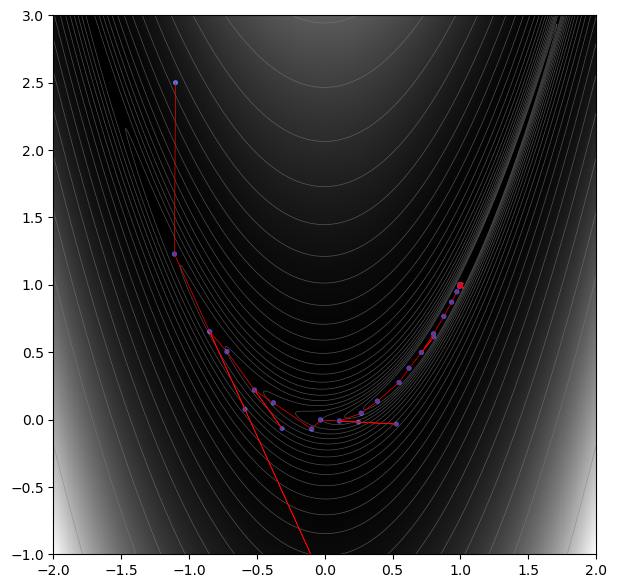

In [3]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.Newton(),
    tz.m.Backtracking()
)
func.run(optimizer, max_steps=25)
func.plot(log_contour=True)

### 4.4 Newton with trust region
Newton can also be used with trust regions as an alternative to line searches. Some trust regions can also prevent it from being stuck on saddle points and maximums.

finished in 0.2s., reached loss = 0                                      


<Axes: >

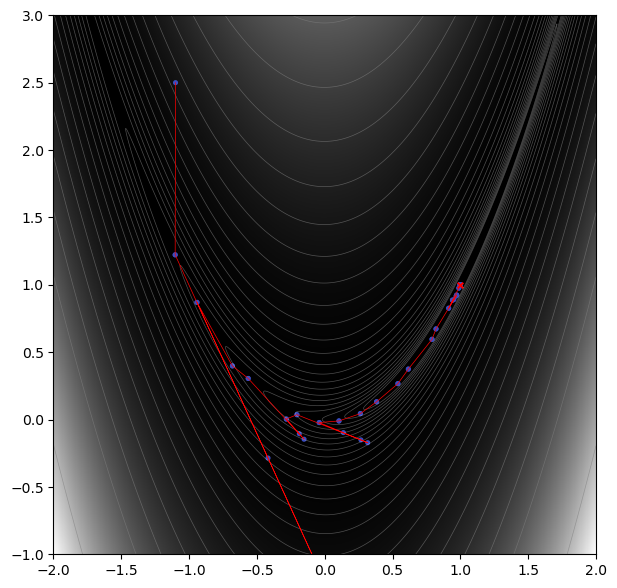

In [13]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.LevenbergMarquardt(tz.m.Newton()),
)
func.run(optimizer, max_steps=25)
func.plot(log_contour=True)

### 4.5 Newton for non-convex functions

As mentioned before, Newton may converge to a maximum or a saddle point instead of a minimum.

A simple modification to avoid converging to saddle points involves adding an identity matrix multiplied by scalar $m$ to the hessian before computing the Newton step. 
$$
x_{t+1} \leftarrow x_t - (H(x_t) + mI)^{-1}\nabla f(x_t)
$$
The scalar $m$ should be selected such that after adding scaled identity matrix to the hessian, all eigenvalues of the hessian become positive. Larger scalars will bring Newton step closer to a gradient descent step, thus some convergence speed may be lost. It may be hard to pick a good scalar without computing the eigendecomposition of the hessian. And if you are willing to compute the eigendecomposition, might as well use the second modification detailed below as it tends to converge much faster.

The second modification of Newton's method to avoid converging to maxima involves modifying the eigenvalues of the hessian in some way to be positive. For example one might take absolute value of the eigenvalues or set all negative eigenvalues to some fixed positive number. A similar modification involves a modified cholesky decomposition which should be cheaper than eigendecomposition, but it isn't implemented in torchzero. Fortunately eigendecomposition is still reasonably cheap compared to cost of computing the hessian in Pytorch, plus it is re-used to invert the hessian.

In torchzero we can pass an eigenvalue transformation into the `eigval_fn` argument, for example ``lambda x: x.abs().clip(min=1e-6)``, or ``lambda x: torch.where(x<1e-8, 1, x)``.


To demonstrate, we will run Newton on the following non-convex function with a saddle point:
$$
f(x,y) = (x-6)^2 + (y - 0.2)^2 + (x * y - 2)^2
$$

We will run Newton fix a small normalized step size to show the trajectory each modification takes, while noting that with a backtracking line search standard Newton also fails to minimize this function.

finished in 3.9s., reached loss = 42.034                                      
finished in 1.9s., reached loss = 0.0177                                      
finished in 1.6s., reached loss = 0.0175                                      


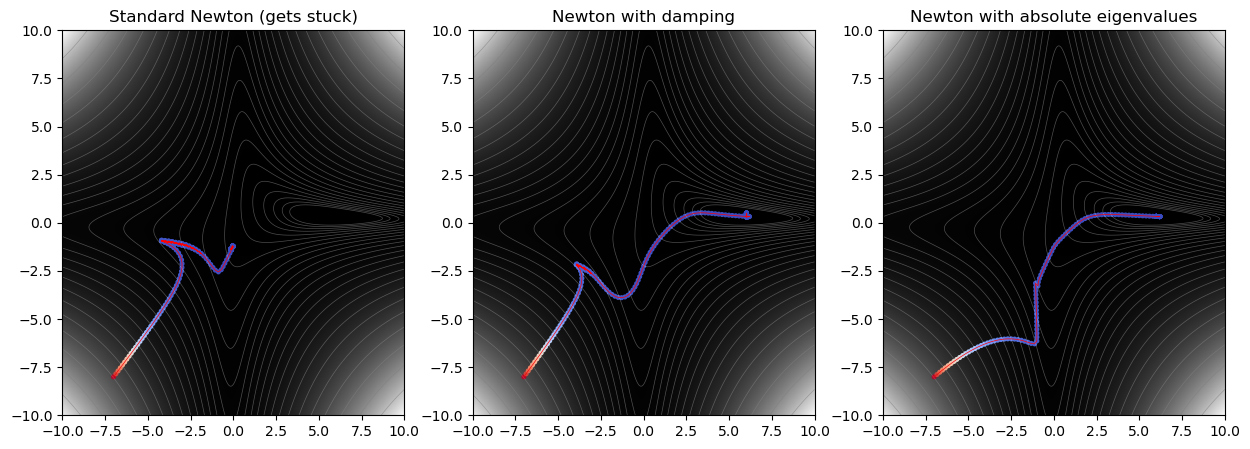

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax = np.ravel(ax)

# --------------------------------- standard --------------------------------- #
func = FunctionDescent('star')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.Newton(),
    tz.m.Normalize(2e-1)
)
func.run(optimizer, max_steps=1000)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Standard Newton (gets stuck)")

func = FunctionDescent('star')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.Newton(damping=10),
    tz.m.Normalize(2e-1)
)
func.run(optimizer, max_steps=500)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Newton with damping")

# ------------------------------ absolute value ------------------------------ #
func = FunctionDescent('star')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.Newton(eigval_fn=lambda x: x.abs().clip(min=1e-8)),
    tz.m.Normalize(2e-1)
)
func.run(optimizer, max_steps=250)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("Newton with absolute eigenvalues")

plt.show()

### 4.6 NewtonCG

Newton has a big disadvantage which is that it requires at least $N^2$ memory to store the hessian. However there are matrix-free iterative methods such as the **Conjugate Gradient** (CG) method that can solve a linear system by using only hessian-vector products and thus require little memory. 

Note that this refers to the linear CG used to solve the linear system, which is different (but related) to the nonlinear CG described in [5. Conjugate gradient](5.%20Conjugate%20gradient.ipynb).

Recall that Newton step is the solution to the following linear system:
$$
H(x_t)v_t = \nabla f(x_t)
$$

Methods like CG can solve this with just hessian-vector products and require at most $n$ hessian-vector products to solve a positive definite $n \times n$ system, i.e. for a problem with $n$ variables (assuming infinite precision). Hessian-vector products can be computed efficiently via autograd or finite difference of two backward passes.

You can actually take any gradient based optimizer and use it to solve the linear system using just hessian-vector products. Torchzero even implements `tz.m.experimental.NewtonSolver`, where you can specify any other pytorch optimizer as the solver, but CG and other specialized iterative methods tend to work better.

When the objective function is non-convex, hessian is non positive definite, and CG is no longer guaranteed to converge. Typically it just converges very slowly and requires many iterations.

On a 2D function NewtonCG behaves identically to Newton. To demonstrate it, we shall solve a large quartic problem which is too large to use Newton.

In [6]:
DIM = 1_000_000
device = 'cuda' if torch.cuda.is_available() else None

y = torch.randn(DIM, device=device)

def quartic(x:torch.Tensor):
    x = x+y
    return x[1:].pow(4).mean() + x[:-1].mean().pow(4) + x[::2].pow(2).mean() + x[1::2].mean().pow(2)

X = torch.randn(DIM, requires_grad=True, device=device)
opt = tz.Modular([X], tz.m.NewtonCG(tol=1e-8),tz.m.Backtracking())

def closure(backward=True):
    loss = quartic(X)
    if backward:
        opt.zero_grad()
        loss.backward()
    return loss

for i in range(1,11):
    loss = opt.step(closure)
    print(f'{i}: {loss = }')

1: loss = tensor(14.0518, device='cuda:0', grad_fn=<AddBackward0>)
2: loss = tensor(2.9000, device='cuda:0', grad_fn=<AddBackward0>)
3: loss = tensor(0.5892, device='cuda:0', grad_fn=<AddBackward0>)
4: loss = tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)
5: loss = tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>)
6: loss = tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
7: loss = tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
8: loss = tensor(7.4932e-05, device='cuda:0', grad_fn=<AddBackward0>)
9: loss = tensor(1.5988e-05, device='cuda:0', grad_fn=<AddBackward0>)
10: loss = tensor(3.7141e-06, device='cuda:0', grad_fn=<AddBackward0>)


### 4.7 Truncated Newton
For large scale optimization performing $n$ hessian-vector products may be too prohibitive. NewtonCG can be truncated by limiting maximum number of CG iteration by some small value, and it will still produce reasonable directions.

On a 2D function CG needs two iterations anyway so we can't truncate it. So we shall solve the same quartic problem.

In [7]:
X = torch.randn(1_000_000, requires_grad=True, device=device)
opt = tz.Modular([X], tz.m.NewtonCG(maxiter=10), tz.m.Backtracking())

def closure(backward=True):
    loss = quartic(X)
    if backward:
        opt.zero_grad()
        loss.backward()
    return loss

for i in range(1,11):
    loss = opt.step(closure)
    print(f'{i}: {loss = }')

1: loss = tensor(14.0203, device='cuda:0', grad_fn=<AddBackward0>)
2: loss = tensor(2.9288, device='cuda:0', grad_fn=<AddBackward0>)
3: loss = tensor(0.5959, device='cuda:0', grad_fn=<AddBackward0>)
4: loss = tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)
5: loss = tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>)
6: loss = tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
7: loss = tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
8: loss = tensor(8.2679e-05, device='cuda:0', grad_fn=<AddBackward0>)
9: loss = tensor(1.8080e-05, device='cuda:0', grad_fn=<AddBackward0>)
10: loss = tensor(4.3785e-06, device='cuda:0', grad_fn=<AddBackward0>)


### 4.8 NewtonCG-Steihaug
Another approach is to utilize truncation in order to implement trust region. When CG solves $Hv=g$, norm of the the direction $v$ increases with each CG iteration. Therefore when $v$ becomes larger than our trust radius or when negative curvature is detected, CG is terminated and $v$ is modified to be within the trust radius and returned. This determines a good step size, terminates CG much earlier thus requiring much less computation, and prevents it from getting stuck on saddle points.

finished in 0.5s., reached loss = 0                                      


<Axes: >

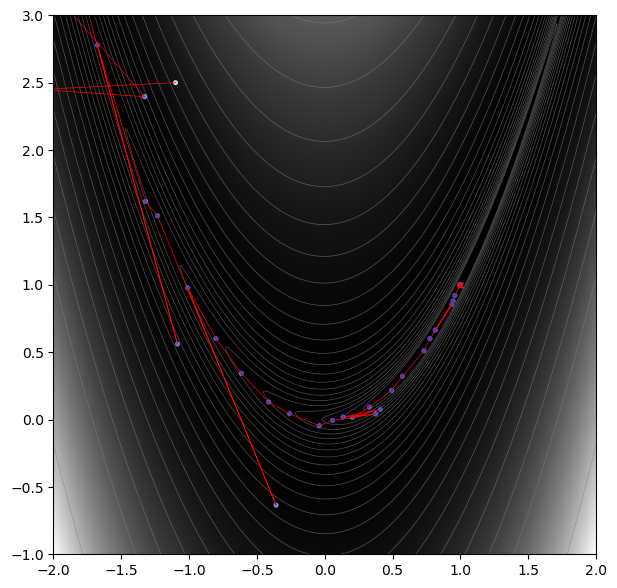

In [9]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.NewtonCGSteihaug(),
)
func.run(optimizer, max_steps=30)
func.plot(log_contour=True)

### 4.9 Zeroth order Newton-CG
When derivatives are not available, we can still use NewtonCG by utilizing a finite difference approximation to both gradients and hessian-vector products. For example even a heavily quantized version of rosenbrock can be minimized by carefully choosing a finite difference step size.

We can pass `hvp_method="central"` to ``NewtonCGSteihaug``, so it will estimate hessian-vector products using two gradient calculations. There is also a `"forward"` formula which uses a single gradient calculation per Hvp (and gradient at $x_t$ is re-used for each Hvp), it is usually accurate enough but for quantized rosenrbock it fails. In both `FDM` (finite-difference gradient approximator) and `NewtonCG`/`NewtonCGSteihaug`, the finite difference step size is controlled by the `h` argument.

finished in 3.7s., reached loss = 0.011                                      


<Axes: >

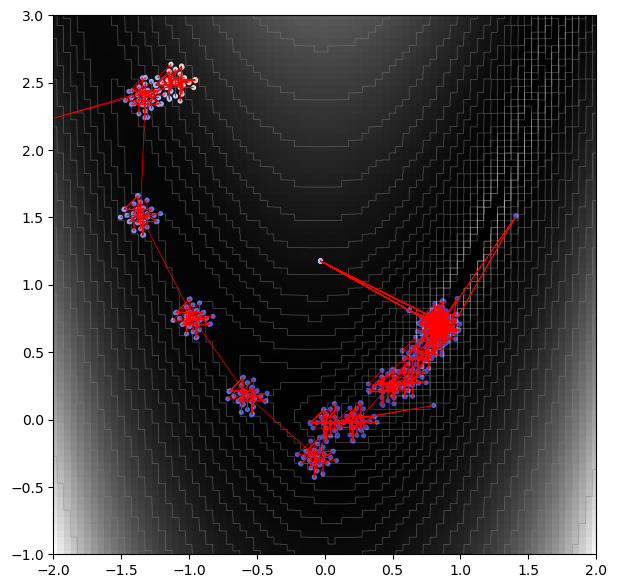

In [7]:
quantization = 20
def quantized_rosen(x:torch.Tensor, y:torch.Tensor):
    x = (x * quantization).round() / quantization
    y = (y * quantization).round() / quantization
    return (1 - x)**2 + 10 * (y - x**2)**2

func = FunctionDescent(quantized_rosen, x0=(-1.1, 2.5), domain=(-2,2,-1,3))
optimizer = tz.Modular(
    func.parameters(),
    tz.m.FDM(formula='central', h=0.1),
    tz.m.NewtonCGSteihaug(hvp_method='central', h=0.05, maxiter=2),
)
func.run(optimizer, max_steps=20)
func.plot(log_contour=True)

### 4.10 Newton for non-smooth functions
When a function is non-smooth, the quadratic model that Newton's method minimizes will only consider smooth terms, and if there are no smooth terms, the hessian will be a zero matrix, so inverse hessian is not even defined.

It is possible to modify Newton to work a little bit better with non-smooth functions, although whether it will work well depends on the function and prevalence of non-smooth terms in it. Newton is only useful if the quadratic model which accounts for just the smooth terms is still useful.

The first modification is to add some trust region. The second modification is to **square** the function, which effectively adds a regularization term preventing Newton from making large steps. To square the function, you literally just square the value:

$$
f_{\text{squared}}(x) = f(x)^2
$$

Or use the `tz.m.SquareHomotopy` module which does the same thing. Alternatively function can be taken to the 4th power, or exponentiated, etc. The squared function can also be added to original with some weight to control regularization strength.

We shall run Newton on the following function
$$
f(x, y) = max(|x|, |y|) + 0.0001 * ((x-5)^4 + (y-5)^4)
$$
The quadratic model only accounts for the $0.0001 * ((x-5)^4 + (y-5)^4)$ term, therefore Newton makes slow progress. By regularizing Newton by squaring the function, or by using a trust region apporach, it is able to converge faster by not making giant steps. In this case the non-smooth term dominates to help visualize it better, so realistically Newton isn't useful there.

finished in 0.2s., reached loss = 0.131                                      
finished in 0.2s., reached loss = 0.125                                      
finished in 0.1s., reached loss = 0.125                                      


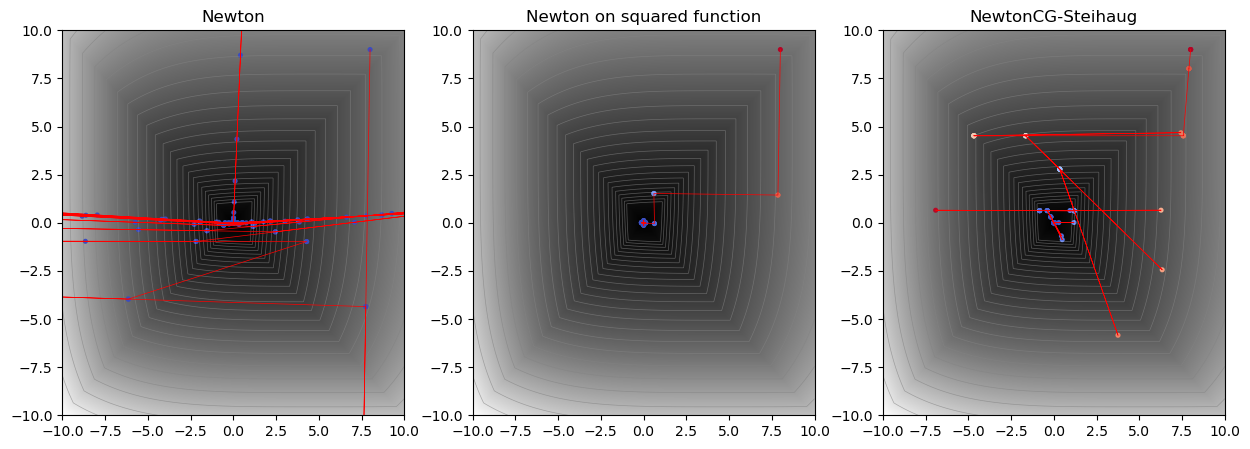

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax = np.ravel(ax)
f = lambda x, y: torch.maximum(x.abs(), y.abs()) + 0.0001 * ((x-5)**4 + (y-5)**4)

# --------------------------------- standard --------------------------------- #
func = FunctionDescent(f, x0=(8,9), domain=(-10,10,-10,10))
optimizer = tz.Modular(
    func.parameters(),
    tz.m.Newton(),
    tz.m.Backtracking()
)
func.run(optimizer, max_steps=20)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Newton")

func = FunctionDescent(f, x0=(8,9), domain=(-10,10,-10,10))
optimizer = tz.Modular(
    func.parameters(),
    tz.m.SquareHomotopy(),
    tz.m.Newton(),
    tz.m.Backtracking()
)
func.run(optimizer, max_steps=20)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Newton on squared function")

# ------------------------------ absolute value ------------------------------ #
func = FunctionDescent(f, x0=(8,9), domain=(-10,10,-10,10))
optimizer = tz.Modular(
    func.parameters(),
    tz.m.NewtonCGSteihaug(hvp_method='forward'),
)
func.run(optimizer, max_steps=20)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("NewtonCG-Steihaug")

plt.show()

### 4.11 Higher order Newton
The $n$-th order version of Newton's method forms and minimizes a polynomial model of the objective function given by it's $n$-th order Taylor polynomial approximation.

When the second order model is defined by the gradient and the hessian matrix, the higher order model also incorporates tensors of higher order derivatives. For example hessian is a 2D tensor (a matrix), 3rd order derivatives are given by a tensor of 3 dimensions, etc. Therefore $n$-th order Newton requires $N^n$ storage to store the tensor of $n$-th order derivatives, where $N$ is number of variables.

Consider that $i,j,k$-th element of the 3rd-order tensor equals 10, that means that there is a term $\frac{10x_ix_jx_k}{3!}$ in the third order model. The 3 factorial comes from taylor series formula, for 4th order it becomes 4 factorial etc. Specifically derivative of $x^3$ is $3x^2$, second derivative is $6x$, which is $3!x$. 

There are actually six such terms given by permutations of $i,j,k$ that are equal to each other - $10x_ix_jx_k$, $10x_ix_kx_j$, $10x_jx_ix_k$, $10x_jx_kx_i$, $10x_kx_ix_j$, $10x_kx_jx_i$. Because there are six terms, and they are divided by six, the sixes actually cancel out.

Unfortunately the higher order model doesn't have a simple solution to find the minima, such as $H^{-1}g$ in Newton, so it itself has to be minimized by an iterative method which is in fact usually 2nd order Newton with a trust region, and isn't even guaranteed to converge. The higher order polynomial has known gradient and hessian that can be computed without relying on autograd. So, there may be very specific cases where Higher order Newton is useful, but in most cases it does not appear to be practical, as both computing higher order derivatives and minimizing the model are very expensive.

As an example, consider rosenbrock function which is is a 4th order polynomial function. Therefore by calculating derivatives up to 4th order, we obtain a perfect model of rosenbrock and by minimizing it, we minimize rosenbrock in a single iteraion.

finished in a very short time, reached loss = 1.68e-10                                      


<Axes: >

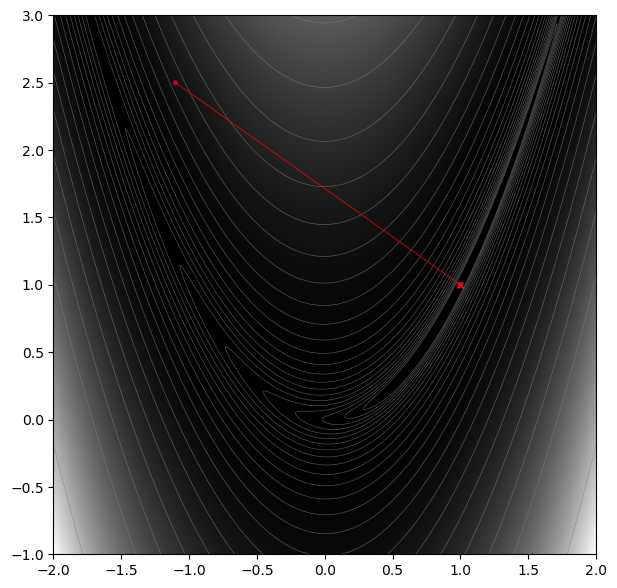

In [11]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.HigherOrderNewton(trust_method=None),
)

func.run(optimizer, max_steps=2)
func.plot(log_contour=True)

### 4.12 NewtonNewton
This is a higher order method that I have devised. Here is how it works:

1. Calculate newton step by solving $Hx=g$ and obtaining $x$.

2. Calculate jacobian of $x$ w.r.t. parameters and call it $H_2$. The procedure of calculating $H_2$ is the same as the procedure of calculating the hessian $H$ as jacobian of $g$ w.r.t. parameters.

3. Solve $H_2 x_2 = x$ for $x_2$. Now $x_2$ is the NewtonNewton direction.

4. Optionally, repeat to get $x_3$ - a NewtonNewtonNewton direction, etc.

NewtonNewton appears to only be suitable for convex functions under ~40 variables where it sometimes outperforms Newton in terms of time needed to converge, but not always. No idea if it has any practical use though.

finished in 0.1s., reached loss = 6.64e-06                                      
finished in 0.0s., reached loss = 7.34e-11                                      


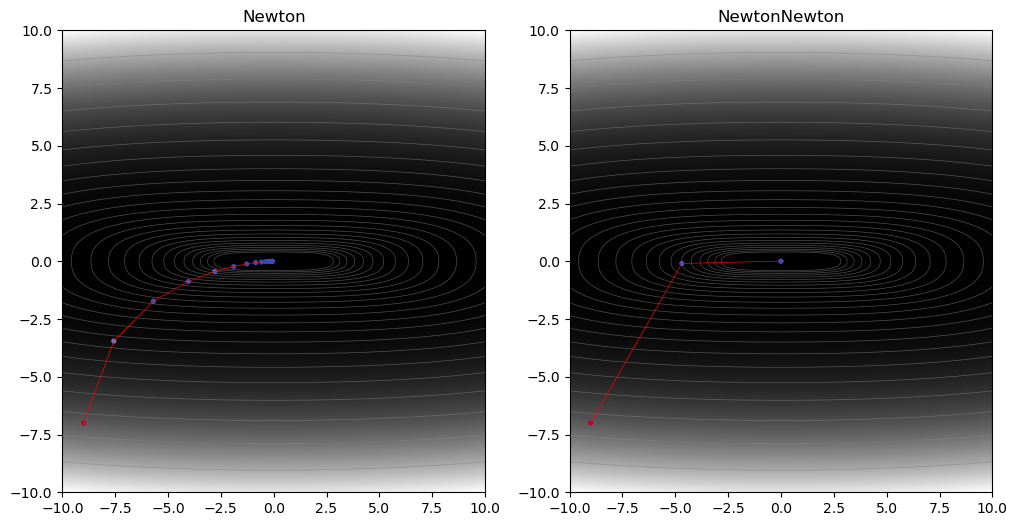

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax = np.ravel(ax)

# f(x, y) = x^4 + 10|y^3| + 10(xy)^2
f = lambda x, y: x**4 + ((10*y)**3).abs() + 10*(x*y)**2

# ---------------------------------- newton ---------------------------------- #
func = FunctionDescent(f, x0=(-9,-7), domain=(-10,10,-10,10))
optimizer = tz.Modular(
    func.parameters(),
    tz.m.Newton(),
)
func.run(optimizer, max_steps=15)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Newton")

# ------------------------------- newton-newton ------------------------------ #
func = FunctionDescent(f, x0=(-9,-7), domain=(-10,10,-10,10))
optimizer = tz.Modular(
    func.parameters(),
    tz.m.experimental.NewtonNewton(),
)
func.run(optimizer, max_steps=4)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("NewtonNewton")

plt.show()